<a href="https://colab.research.google.com/github/dan-manolescu/data-structures-fun/blob/main/C8_Spatial_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quadtrees

Imports needed for the code to run:


In [75]:
from typing import List
from math import sqrt

A few helper functions:
* approx_equal: to determine based on floating point precision if two points are equal
* euclidean_dist: to calculate the Euclidean dist between two points

In [76]:
# threshold to be set based on desired numerical precision.
threshold = 0.0

def approx_equal(x1: float, y1: float, x2: float, y2: float) -> bool:
    '''
    Returns True if both points are wihin a threshold distance in both dimensions.
    '''
    if abs(x1 - x2) > threshold:
        return False
    if abs(y1 - y2) > threshold:
        return False
    return True

def euclidean_dist(x1: float, y1: float, x2: float, y2: float) -> float:
    return sqrt((x1 - x2)**2 + (y1 - y2)**2)

Point class used to represent a point, identified by x and y coordinates.

In [77]:
class Point:
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y

A QuadTreeNode class used to represent a node in a QuadTree. A node can be an internal node or a leaf node.
An internal node has a maximum of 4 children nodes.
A leaf node has no childrens and instead has a list of the points contained within the node.
Each node has boundaries for the points contained (x_min - x_max and y_min - y_max) as well as the number of points contained (in itself if it's a leaf or the total of its children if it's an internal node).

In [78]:
class QuadTreeNode:
    def __init__(self, x_min: float, x_max: float, y_min: float, y_max: float):
        self.is_leaf = True
        self.num_points = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        # QuadTreeNode childrens (maximum of 4) only if it's not a leaf
        self.children = [[None for _ in range(2)] for _ in range(2)]
        # List of internal Points (if it's a leaf).
        self.points = []

    def QuadTreeNodeInsert(self, x: float, y: float) -> None:
        '''
        Adds a new point to the QuadTreeNode by traversing the tree to find
        the new point location. Ending up at a leaf node adds the point there.
        Ending up at an internal node created the necessary node there.
        '''
        # Increment the number of points with the new point being added
        self.num_points += 1

        # Determine into which child bin the point should go.
        # We only use 4 bins, so xbin and ybin can only be (0, 1).
        x_bin_size = (self.x_max - self.x_min) / 2
        y_bin_size = (self.y_max - self.y_min) / 2
        xbin = int((x - self.x_min) / x_bin_size)
        ybin = int((y - self.y_min) / y_bin_size)

        # Add the point to the correct child.
        if not self.is_leaf:
            # Check first if the child exists and if not create it
            if self.children[xbin][ybin] == None:
                self.children[xbin][ybin] = QuadTreeNode(
                    self.x_min + xbin * x_bin_size,
                    min(self.x_min + (xbin + 1) * x_bin_size, self.x_max),
                    self.y_min + ybin * y_bin_size,
                    min(self.y_min + (ybin + 1) * y_bin_size, self.y_max)
                )
            self.children[xbin][ybin].QuadTreeNodeInsert(x, y)
            return

        # Add the point to a leaf node and split if needed.
        self.points.append(Point(x, y))

        # Check if conditions for a split are met:
        #  1. Do we have enough points to justify a split? (i.e. sufficient distinct points)
        #  2. Are the spatial bounds large enough to justify a split? (i.e. have we reached the min partition size)
        #  3. Have we hit our maximum spatial depth? (i.e have we reached the max desired tree depth)

        # For simplicity sake we only check here if we have more than one point.
        if len(self.points) > 1:
            # Mark the node as no longer a leaf.
            self.is_leaf = False
            # For each point insert it into the proper quadnode childrens.
            for pt in self.points:
                self.QuadTreeNodeInsert(pt.x, pt.y)
            # Correct the num_points to avoid double-counting the re-inserted points
            # due to the counter increment at the beginning of QuadTreeInsert.
            self.num_points -= len(self.points)
            # Clear the list of points since this is now an internal node.
            self.points = []

    def QuadTreeNodeCollapse(self) -> List[Point]:
        '''
        Helper method to collapse a node that no longer meets the splitting criteria.
        Returns a list with all the subtree points.
        '''
        # First check if the node is a leaf and then directly return the list of points.
        if self.is_leaf:
            return self.points

        # If the node is internal then aggregate the points from each child.
        # Call recursively QuadTreeNodeCollapse on each non-null children.
        for i in (0, 1):
            for j in (0, 1):
                if self.children[i][j] != None:
                    sub_pts = self.children[i][j].QuadTreeNodeCollapse()
                    self.points += sub_pts
                    self.children[i][j] = None

        # Set the node as leaf (no more childrens)
        self.is_leaf = True
        return self.points

    def QuadTreeNodeDelete(self, x: float, y: float) -> bool:
        '''
        The function deletes a point identified by x and y by recursively
        going down the tree. When it reaches a leaf it deletes the point
        if it exists and then returns up the tree by collapsing nodes as needed.
        Returns True if the point was deleted.
        '''
        # Base condition for recursive calls: we have reached a leaf node.
        if self.is_leaf:
            # Iterate through the list of points and check if any matches
            # the target point.
            for point in self.points:
                if approx_equal(point.x, point.y, x, y):
                    # Remove the point from the list, decrements the count of points
                    # for this node and return True to indicate a succesful deletion.
                    self.points.remove(point)
                    self.num_points -= 1
                    return True
            # There is no matching point in this leaf.
            return False

        # Determine into which child bin the point to be removed would go.
        x_bin_size = (self.x_max - self.x_min) / 2
        y_bin_size = (self.y_max - self.y_min) / 2
        xbin = int((x - self.x_min) / x_bin_size)
        ybin = int((y - self.y_min) / y_bin_size)

        # Check if the correct child exists.
        if self.children[xbin][ybin] == None:
            return False

        # Recursively call QuadTreeNodeDelete on this child.
        if self.children[xbin][ybin].QuadTreeNodeDelete(x, y):
            # The code has deleted a point from one of the children nodes
            # so update the count of points
            self.num_points -= 1

            # Check if the child is empty and if so delete the child node.
            if self.children[xbin][ybin].num_points == 0:
                self.children[xbin][ybin] = None

            # Collapse the node if it no longer meets the split conditions to be an internal node.
            # For simplicity sake the split conditions only assume more than
            # one point.
            if self.num_points <= 1:
                self.points = self.QuadTreeNodeCollapse()
            # Indicate deletion was succesful.
            return True
        # At this point the recursive calls have not deleted any node.
        return False

    def MinDist(self, x: float, y: float) -> float:
        '''
        Helper function to compute the distance from the target point (x,y) to a node.
        '''
        x_dist = 0.0
        if x < self.x_min:
            x_dist = self.x_min - x
        if x > self.x_max:
            x_dist = x - self.x_max

        y_dist = 0.0
        if y < self.y_min:
            y_dist = self.y_min - y
        if y > self.y_max:
            y_dist = y - self.y_max

        return sqrt(x_dist**2 + y_dist**2)

    def QuadTreeNodeNearestNeighbor(self, x: float, y: float, best_dist: float) -> Point:
        '''
        Recursive search for nearest neighbor to our target point (x, y).
        best_dist represents the best distance so far and is used for our pruning logic.
        If the minimum distance to the current node is greater than the best distance
        so far then terminate this search branch.
        Returns a point that is closer than best_dist or None otherwise.
        '''
        # Prune if the node is too far away.
        if self.MinDist(x, y) >= best_dist:
            return None

        best_candidate = None

        # If we are in a leaf, search the points.
        if self.is_leaf:
            for current in self.points:
                dist = euclidean_dist(x, y, current.x, current.y)
                if dist < best_dist:
                    best_dist = dist
                    best_candidate = current
            return best_candidate

        # Recursively check all 4 children starting with the closest.
        x_bin_size = (self.x_max - self.x_min) / 2
        y_bin_size = (self.y_max - self.y_min) / 2
        xbin = int((x - self.x_min) / x_bin_size)
        if xbin < 0:
            xbin = 0
        if xbin > 1:
            xbin = 1

        ybin = int((y - self.y_min) / y_bin_size)
        if ybin < 0:
            ybin = 0
        if ybin > 1:
            ybin = 1

        # Recursively explore the non-null children.
        for i in (xbin, (xbin+1) % 2):
            for j in (ybin, (ybin+1) % 2):
                if self.children[i][j] != None:
                    quad_best = self.children[i][j].QuadTreeNodeNearestNeighbor(x, y, best_dist)
                    if quad_best != None:
                        # We have found a closer point so update best_candidate and best_dist
                        best_candidate = quad_best
                        best_dist = euclidean_dist(x, y, quad_best.x, quad_best.y)
        # best_candidate will be None if no point closer than best_dist has been found.
        return best_candidate

A QuadTree class to represent a quad tree. Each quad tree consists of an initialized QuadTreeNode root.

In [79]:
class QuadTree:
    def __init__(self, x_min: float, x_max: float, y_min: float, y_max: float):
        self.root = QuadTreeNode(x_min, x_max, y_min, y_max)

    def QuadTreeInsert(self, x: float, y: float) -> bool:
        '''
        Inserts a new point defined by x and y into the QuadTree.
        It checks that the inserted point falls within the quadtree bounds.
        Returns False if the point is out of range.
        '''
        if x < self.root.x_min or x > self.root.x_max:
            return False
        if y < self.root.y_min or y > self.root.y_max:
            return False
        self.root.QuadTreeNodeInsert(x, y)
        return True

    def QuadTreeDelete(self, x: float, y: float) -> bool:
        '''
        Deletes a point from the QuadTree by checking if the point lies
        in the bounds of the QuadTree and then recursively calling the delete
        function of the nodes.
        Returns True if a point was deleted.
        '''
        if x < self.root.x_min or x > self.root.x_max:
            return False
        if y < self.root.y_min or y > self.root.y_max:
            return False
        return self.root.QuadTreeNodeDelete(x, y)

    def QuadTreeNearestNeighbor(self, x: float, y: float) -> Point:
        '''
        Return the nearest neighbor in the tree for our target point (x, y).
        '''
        # Do not check if the target point falls within the bounds of the tree.
        # This can be used to find neighbors for points that fall outside the tree.
        # Start with best_dist as Infinity.
        return self.root.QuadTreeNodeNearestNeighbor(x, y, float('Inf'))

Helper function to draw the quad tree. Quad tree will be drawn as a series of rectangles (one for each children node). Points contained within the leaf nodes are also drawn in blue color.
User can specify a target point which will be drawn as a red X together with the line towards the nearest neighbor in the quad tree.

In [80]:
def visualize_quad_tree(quad_tree: QuadTree, target_pt: Point=None) -> None:
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    fig, ax = plt.subplots()

    ax.set_aspect('equal')
    ax.set_xlabel('X-Coordinate')
    ax.set_ylabel('Y-Coordinate')
    ax.set_title('Quad Tree')

    def draw_rectangle(node: QuadTreeNode, ax):
        ax.add_patch(plt.Rectangle(xy=(node.x_min, node.y_min), width=node.x_max - node.x_min, height=node.y_max - node.y_min, color='black', fill=False))
        if node.is_leaf:
            x_coord = []
            y_coord = []
            for current in node.points:
                x_coord.append(current.x)
                y_coord.append(current.y)
            ax.scatter(x_coord, y_coord, c='blue')
        else:
            for i in (0, 1):
                for j in (0, 1):
                    if node.children[i][j] != None:
                        draw_rectangle(node.children[i][j], ax)

    draw_rectangle(quad_tree.root, ax)

    if target_pt != None:
        ax.plot(target_pt.x, target_pt.y, color='red', marker='X')
        closest_pt = quad_tree.QuadTreeNearestNeighbor(target_pt.x, target_pt.y)
        if closest_pt != None:
            ax.plot([target_pt.x, closest_pt.x], [target_pt.y, closest_pt.y], color='green', linestyle='-')
            circle = Circle((target_pt.x, target_pt.y),
                            euclidean_dist(target_pt.x, target_pt.y, closest_pt.x, closest_pt.y),
                            linestyle=':', fill=False, linewidth=2, color='green')
            ax.add_patch(circle)

    plt.show()


Here we create a quad tree with 11 points and then draw it, also showing a target point and a visual indicator to its nearest neighbor

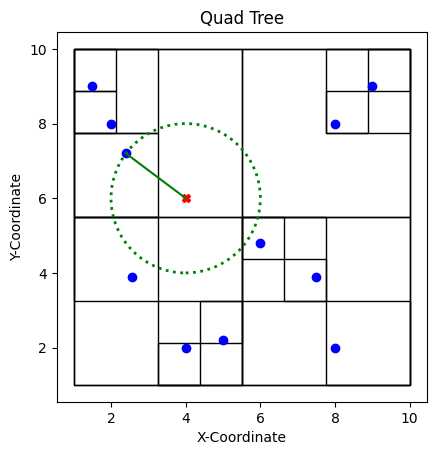

In [81]:
quad_tree = QuadTree(1.0, 10.0, 1.0, 10.0)
quad_tree.QuadTreeInsert(1.5, 9.0)
quad_tree.QuadTreeInsert(2.0, 8.0)
quad_tree.QuadTreeInsert(2.4, 7.2)
quad_tree.QuadTreeInsert(2.55, 3.9)
quad_tree.QuadTreeInsert(4.0, 2.0)
quad_tree.QuadTreeInsert(5.0, 2.2)
quad_tree.QuadTreeInsert(6.0, 4.8)
quad_tree.QuadTreeInsert(7.5, 3.9)
quad_tree.QuadTreeInsert(8.0, 2.0)
quad_tree.QuadTreeInsert(8.0, 8.0)
quad_tree.QuadTreeInsert(9.0, 9.0)

visualize_quad_tree(quad_tree, Point(4, 6))

Here we remove the point indicated previously as nearest neighbor for our targer point. The tree collapses its children nodes as needed and a new closest neighbor is identified.

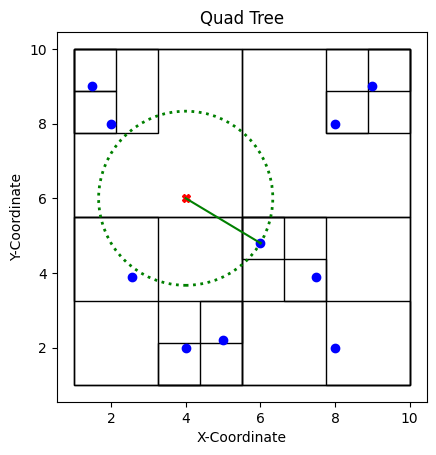

In [82]:
quad_tree.QuadTreeDelete(2.4, 7.2)
visualize_quad_tree(quad_tree, Point(4,6))

Just another example with removing a point from the quad tree and the rearranging of its children.

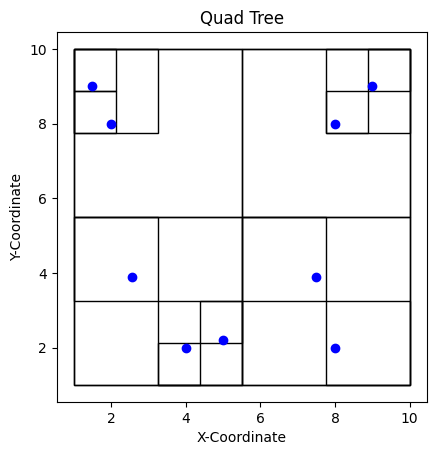

In [83]:
quad_tree.QuadTreeDelete(6.0, 4.8)
visualize_quad_tree(quad_tree)

# k-d Trees